In [1]:
def  extractFileName ( abs_path):

    import os
    if os.name == "nt":
        split_char = '\\' 
    else:
        split_char = '/' 
    if '\\' in abs_path:
        # "  Windows Path " 
#         print ("windows path")
#         print (abs_path )
        image_name = abs_path.split ('\\')[-3] \
                            + split_char + abs_path.split ('\\')[-2] \
                            + split_char + abs_path.split ('\\')[-1]

    else:
        # "  Unix Path " 
        image_name = abs_path.split ('/')[-3] \
                            + split_char + abs_path.split ('/')[-2] \
                            + split_char + abs_path.split ('/')[-1]

    return image_name

In [2]:
import os
import csv
import cv2
import numpy as np
import glob

samples = []
shape = 64

for name in glob.glob("./data/*.csv"):
    print ( "Reading from logfile = " + name)
    with open(name)  as csvfile:
            reader = csv.reader(csvfile)
            for line in reader:
                left_image_name   = extractFileName( line[1])
                right_image_name  = extractFileName( line[2])
                center_image_name = extractFileName( line[0])

#                 print(left_image_name)
                left_image = cv2.imread(left_image_name)
                left_image = cv2.cvtColor (left_image, cv2.COLOR_BGR2RGB)
                left_image = cv2.resize(left_image,(shape,shape ))

                right_image = cv2.imread(right_image_name)
                right_image = cv2.cvtColor (right_image, cv2.COLOR_BGR2RGB)
                right_image = cv2.resize(right_image,(shape,shape ))

                center_image = cv2.imread(center_image_name)
                center_image = cv2.cvtColor (center_image, cv2.COLOR_BGR2RGB)
                center_image = cv2.resize(center_image,(shape,shape ))
                samples.append([center_image, left_image,right_image , float(line[3])] )

samples =np.array(samples)
                
print ( "Total samples found  : " + str(len(samples)))




Reading from logfile = ./data/track2_run1.csv
Reading from logfile = ./data/run5.csv
Reading from logfile = ./data/run6.csv
Reading from logfile = ./data/track2_run4.csv
Reading from logfile = ./data/track2_run2.csv
Reading from logfile = ./data/run2.csv
Reading from logfile = ./data/run1.csv
Reading from logfile = ./data/track2_run3.csv
Reading from logfile = ./data/run4.csv
Reading from logfile = ./data/run3.csv
Reading from logfile = ./data/run7.csv
Total samples found  : 14637


In [3]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print ("Train samples  = {}".format(train_samples.shape[0]))
print ("Validation samples  = {}".format(validation_samples.shape[0]))

Train samples  = 11709
Validation samples  = 2928


In [4]:
import cv2
import numpy as np
import sklearn


def generator(generator_samples, batch_size=256, shape = 64):
    num_samples = len(generator_samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = generator_samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                
                left_image   = batch_sample[1]
                right_image  = batch_sample[2]
                center_image = batch_sample[0]
                
                stearing_angle = float(batch_sample[3])
                #if stearing_angle != 0:
               # create adjusted steering measurements for the side camera images
                correction = 0.2 # this is a parameter to tune
                steering_left = stearing_angle + correction
                steering_right = stearing_angle - correction

                images.append(center_image)
                angles.append(stearing_angle)

                images.append(left_image)
                angles.append(steering_left)

                images.append(right_image)
                angles.append(steering_right)


                # augmented center image
                images.append(cv2.flip(center_image,1))
                angles.append(stearing_angle*-1.0)

                # augmented left image
                images.append(cv2.flip(left_image,1))
                angles.append(steering_left*-1.0)

                # augmented left image
                images.append(cv2.flip(right_image,1))
                angles.append(steering_right*-1.0)

            # end of the batch, yield the images gathered
            yield sklearn.utils.shuffle(np.array(images) , np.array(angles))
            #return sklearn.utils.shuffle(X_train ) #, y_train)

In [5]:
# import matplotlib.pyplot as plt
# # # Visualizations will be shown in the notebook.
# %matplotlib inline
# plt.figure(figsize=(32, 15))

# a = generator(train_samples,1)
# print(a)
# print (np.array(a))
# plt.subplot(5, 5, 1)
# plt.imshow(a[0])
# # plt.subplot(5, 5, 2)
# # plt.imshow(a[1])
# plt.show

In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Activation, Dropout, Reshape
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
# Data Preprocessing ( Normalization and mean centering)
# model.add(Cropping2D(cropping =((45,15),(0,0)), input_shape = (64,64,3), name ="cropping") )
model.add(Cropping2D(cropping =((22,7),(0,0)), input_shape = (64,64,3), name ="cropping") )
model.add(Lambda(lambda x: x/127.5 - 1. , input_shape = (64,64,3)))

model.add(Conv2D(36, (3, 3), activation='elu', padding='valid',strides=(2, 2), name = "Conv1",kernel_initializer='random_uniform',bias_initializer='zeros'))

model.add(Dropout(0.5))

model.add(Conv2D(48, (3, 3), activation='elu', padding='valid',strides=(2, 2), name = "Conv2",kernel_initializer='random_uniform',bias_initializer='zeros'))
model.add(Dropout(0.5))

model.add(Conv2D(64, (2, 2), activation='elu', padding='valid',strides=(2, 2), name = "Conv3",kernel_initializer='random_uniform',bias_initializer='zeros'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (1, 1), activation='elu',padding='valid', strides=(1, 1), name = "Conv4",kernel_initializer='random_uniform',bias_initializer='zeros'))
model.add(Dropout(0.5))

# model.add(Conv2D(64, 3, 3, activation='elu', border_mode='valid',subsample=(1, 1)))
# model.add(Dropout(0.5))

# model.add(Conv2D(64,3,3,name = "Layer5_Conv2D"))
# model.add(Activation('elu',name = "Layer5_Activation"))
# model.add(MaxPooling2D(name = "Layer5_MaxPooling2D"))
model.add(Flatten())

model.add(Dense(100, activation='elu',kernel_initializer='random_uniform',bias_initializer='zeros'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='elu',kernel_initializer='random_uniform',bias_initializer='zeros'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='elu',kernel_initializer='random_uniform',bias_initializer='zeros'))
model.add(Dense(1,kernel_initializer='random_uniform',bias_initializer='zeros'))

model.compile(loss='mse', optimizer='adam')

print (model.summary())

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping (Cropping2D)        (None, 35, 64, 3)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 35, 64, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 17, 31, 36)        1008      
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 31, 36)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 8, 15, 48)         15600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 15, 48)         0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 4, 7, 64)          12352     
__________

In [7]:
train_samples_number =  train_samples.shape[0]
train_samples_number

11709

/home/cristianku/anaconda3/envs/carnd-term1-gpu/lib/python3.5/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
68/68 [============================>.] - ETA: 0s - loss: 0.0813

/home/cristianku/anaconda3/envs/carnd-term1-gpu/lib/python3.5/site-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


69/68 [==============================] - 51s - loss: 0.0811 - val_loss: 0.0615
Total number of train samples: 11709 ( shape 64x64)
Batch Size                   : 1024
Duration                     : 0:00:52.059601
  
 .. model saved to model.h5 
  
dict_keys(['val_loss', 'loss'])


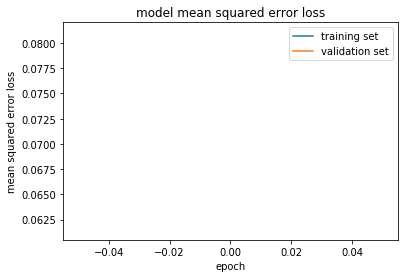

In [9]:
from datetime import datetime
start_time = datetime.now()
    
# compile and train the model using the generator function
batch_size = 1024
train_generator = generator(train_samples, batch_size)
validation_generator = generator(validation_samples, batch_size)

# from keras import optimizers
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
from keras import metrics
                    
model.compile(loss='mse', optimizer='adam')
# model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])

train_samples_number       =  train_samples.shape[0]
validation_samples_number =  validation_samples.shape[0]

history_object = model.fit_generator(train_generator, steps_per_epoch= \
            train_samples_number*3*2/batch_size, validation_data=validation_generator, \
            validation_steps=validation_samples_number*3*2/batch_size, epochs=1, \
            verbose = 1, workers = 2, use_multiprocessing=True)

end_time = datetime.now()
print('Total number of train samples: {} ( shape 64x64)'.format(train_samples_number))
print('Batch Size                   : {}'.format(batch_size))
print('Duration                     : {}'.format(end_time - start_time))
from keras.models import save_model

save_model(model, "model.h5")
print ( "  ")
print ( " .. model saved to model.h5 ")
print ( "  ")


### print the keys contained in the history object
print(history_object.history.keys())

import matplotlib.pyplot as plt
# # # Visualizations will be shown in the notebook.
%matplotlib inline

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()






### show intermediate file

In [9]:
import cv2
from keras.models import load_model
from keras.models import Model

modelobj = load_model('model.h5')


In [10]:
# Load test images
import cv2
import numpy as np
test_images = []

image = cv2.imread('./test_images/center1.jpg')
image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(64,64 ))     
test_images.append(image)

image = cv2.imread('./test_images/center2.jpg')
image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(64,64 ))     
test_images.append(image)


test_images = np.array(test_images)


In [11]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'cropping'
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
intermediate_output.shape


(2, 35, 64, 3)

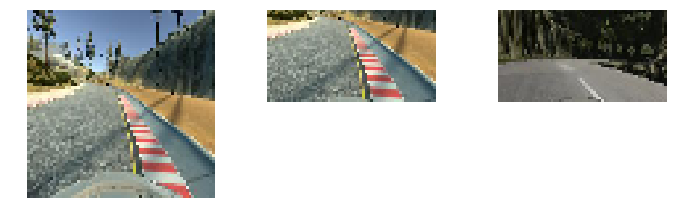

In [12]:
# Show the cropped images
depth = 0 
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
new_image = []
plt.subplot(5, 5, 1 )
plt.axis('off')
plt.imshow(test_images[0])
i = 1
for single_output in intermediate_output:
        i += 1
        plt.subplot(10, 5, i )
        plt.axis('off')
        single_output = single_output.astype(np.uint8)
        plt.imshow(single_output)
plt.show()    


In [13]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'Conv3'
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
intermediate_output[0].shape

(4, 7, 64)

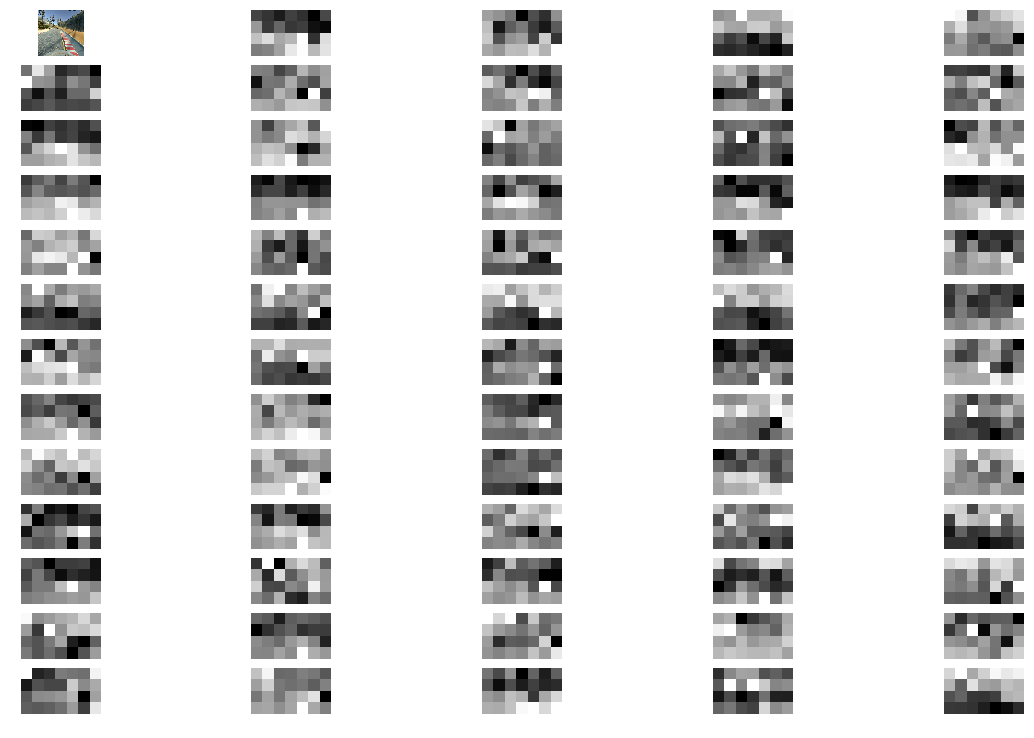

In [14]:
# Show each single layer as a grayscale
depth = 0 
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
new_image = []
plt.subplot(20, 5, 1 )
plt.axis('off')
plt.imshow(test_images[0])
for single_output in intermediate_output:
    for i in range(0,single_output.shape[2]):
        plt.subplot(20, 5, i+2 )
        plt.axis('off')
        plt.imshow(single_output[:,:,i],cmap='gray')
plt.show()       

In [15]:
intermediate_output.shape[3]


64

### Model Visualization

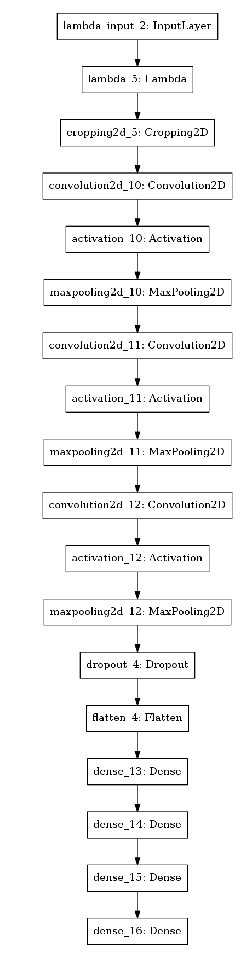

In [11]:
import cv2
from keras.utils.visualize_util import plot
from keras.models import load_model
%matplotlib inline

#visualize the model
modelobj = load_model('model.h5')
plot (modelobj, to_file='model.png')
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 100))
image = cv2.imread('model.png')
image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
plt.subplot(5, 5, 1)
plt.axis('off')

plt.imshow(image)
plt.show()
